In [1]:
from neuron import h
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
h.load_file("nrn/cells/BC_Euler9_ON.hoc") 
h.load_file("nrn/cells/RGC_20170907_S2W1C1.hoc")
import numpy as np
import matplotlib.pyplot as plt
import time as _time
import helperFuns as hF
from matplotlib.lines import Line2D


from BC_model_template import ONBipolarCell
from RGC_model_template import DummyRGC
from plots import plot_cell, plot_cell_with_electrode, plot_bc_rgc

--No graphics will be displayed.


In [ ]:
#%matplotlib widget

# Morphology

In [3]:
def move_rgc_along_z(self, distance):
    """Move RGC along z-axis by specified distance (µm)."""
    # The line 'self.z += distance' is the cause of the error.
    # It should be removed as the HocObject does not have a 'z' attribute.
    
    for sec in self.all:
        for i in range(sec.n3d()):
            sec.pt3dchange(
                i,
                sec.x3d(i),
                sec.y3d(i),
                sec.z3d(i) + distance, # The movement happens here
                sec.diam3d(i)
            )

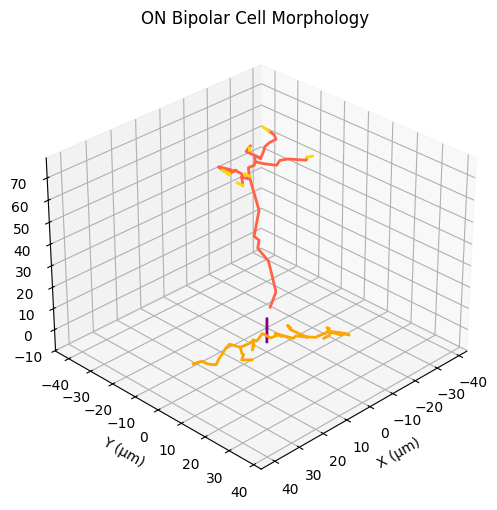

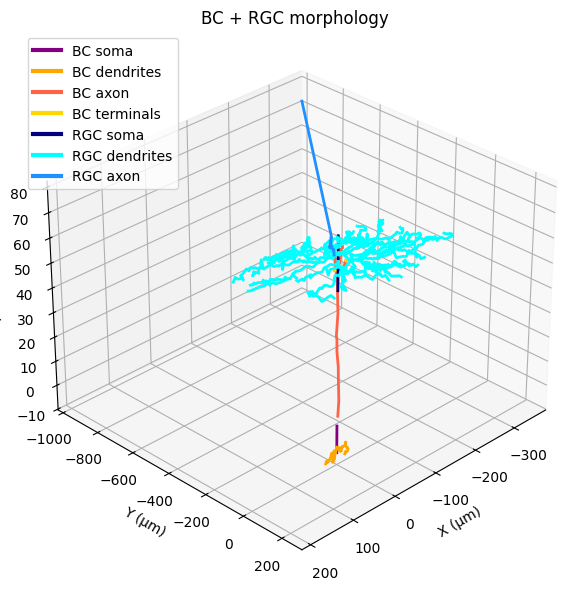

In [4]:
bc = ONBipolarCell()
rgc = DummyRGC()
move_rgc_along_z(rgc, 70)
plot_cell(bc)
plot_bc_rgc(bc, rgc)

In [ ]:
# # plot all rgc cells that are in the folder 'nrn/cells' and are not called 'BC_EUler9_ON'

# import os
# import glob
# rgc_files = glob.glob('nrn/cells/*.hoc')
# # remove 'BC_Euler9_ON.hoc' from the list
# rgc_files = [f for f in rgc_files if 'BC_Euler9_ON' not in f]
# for rgc_file in rgc_files:
#     # load the rgc cell
#     h.load_file(rgc_file)
#     # get the class name from the file name
#     class_name = os.path.basename(rgc_file).replace('.hoc', '')
#     # create an instance of the rgc cell
#     rgc_cell = getattr(h, class_name)()
#     # create an instance of the bc cell
#     bc_cell = ONBipolarCell()
#     # plot both cells
#     plot_bc_rgc(bc_cell.cell, rgc_cell)

# Stim

In [5]:
def PointSource_Stim(duration=15, amplitude=10.0, stimXShift=0, stimYShift=0, stimZShift=50):
    Stim = {}   
    # General 
    Stim['ID'] = 1  
    Stim['reset'] = 1  
    Stim['vInit'] = -50  # membrane potential to initialize model (mV)
    Stim['type'] = 'extracellular' 
    Stim['amp'] = amplitude
    # Extracellular
    Stim['elec'] = 'point'  # electrode type ('point' or 'disk'), for 'extracellular' only
    #Stim['rDisk'] = 20  # electrode radius um, for 'disk' only
    Stim['rhoExt'] = 1000  # extracellular resisitivity (Ohm*cm), for 'point' & 'disk' only
    Stim['stimXShift'] = stimXShift  # electrode x-shift (um), for 'point' & 'disk' only
    Stim['stimYShift'] = stimYShift  # electrode y-shift (um), for 'point' & 'disk' only
    Stim['stimZShift'] = stimZShift  # electrode z-shift (um), for 'point' & 'disk' only
    Stim['cellXShift'] = 0  # cell x-shift (um)
    Stim['cellYShift'] = 0  # cell y-shift (um)
    Stim['cellZShift'] = 0  # cell z-shift (um)
    Stim['theta_z'] = 0  # cell z-rotation (deg)
    Stim['theta_x'] = 0  # cell x-rotation (deg)

    ### Temporal parameters
    Stim['stop'] = duration + 10  # total duration of simulation (ms)
    Stim['dt'] = 0.005  # time step of simulation (ms)
    Stim['initDur'] = 10  # duration of initialization procedure (ms)
    Stim['initDt'] = 10  # time step of initialization procedure (ms), dt=1e10 computes steady state in one step
    Stim['del'] = 1  # delay until stim is turned on (ms)
    Stim['dur'] = duration # duration of stim (ms)
    Stim['pulseShape'] = 'mono'  # pulse shape ('mono' or 'bi')
    #Stim['pulseRatio'] = [1,-1]  # ratio between leading and balancing pulse, for 'bi' only
    Stim['spike_threshold'] = 0.0  # Spike threshold based on your plot
    return Stim

### Test Stimulation

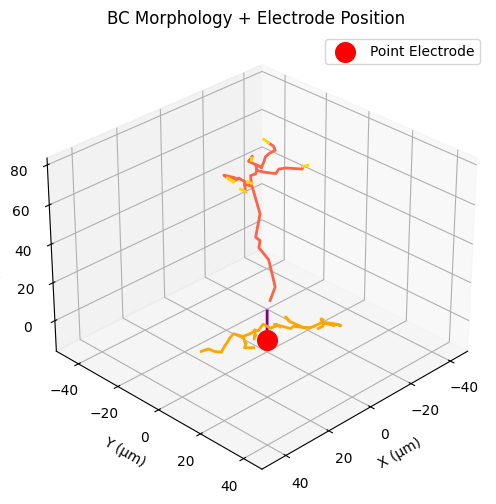

In [11]:
Stim = PointSource_Stim(duration=15, amplitude=10.0, stimZShift=-10)
plot_cell_with_electrode(bc, Stim)

--- Running the model took 3.64 secs


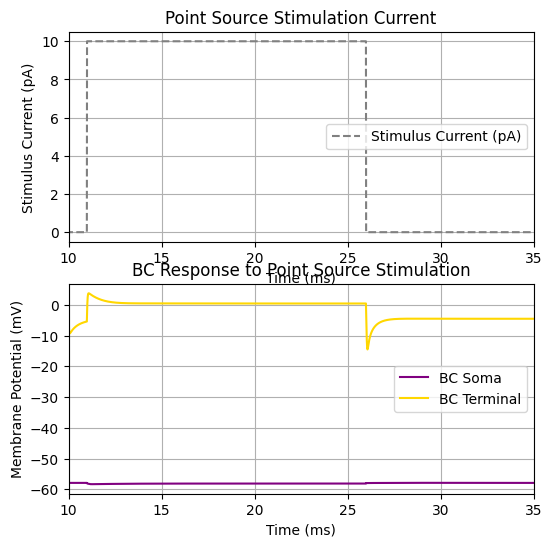

In [19]:
tsvec, isvec = hF.setStimTemp(Stim)

if Stim['type'] == 'iClamp':
    ic = hF.setStimIClamp(bc, tsvec, isvec)
    isvec.play(ic._ref_amp, tsvec)
elif Stim['type'] == 'extracellular':
    hF.setStimTransferImpedance(Stim, bc)
    isvec.play(h._ref_is_xtra, tsvec, 1)   


tRec = h.Vector().record(h._ref_t)
vRecSoma = h.Vector().record(bc.soma(0.5)._ref_v)
term_list = [sec for sec in bc.terminal]
vRecTerm = h.Vector().record(term_list[0](0.5)._ref_v)


### Initialize and run model
Tic = _time.time()
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

h.tstop = Stim['initDur'] + Stim['stop']
h.dt = Stim['dt']
h.continuerun(h.tstop)
Toc = _time.time()
print('--- Running the model took %.2f secs' % (Toc - Tic))

# plot results
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(tsvec,isvec*1e3, label='Stimulus Current (pA)', color='gray', linestyle='--')
plt.xlim(Stim['initDur'], Stim['initDur']+Stim['stop'])
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus Current (pA)')
plt.title('Point Source Stimulation Current')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(tRec, vRecSoma, label='BC Soma', color='purple')
plt.plot(tRec, vRecTerm, label='BC Terminal', color='gold')
plt.xlim(Stim['initDur'], Stim['initDur']+Stim['stop'])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('BC Response to Point Source Stimulation')
plt.legend()
plt.grid()
plt.show()


# Connect BC and RGC

In [9]:
rgc = DummyRGC()
bc = ONBipolarCell()
move_rgc_along_z(rgc, 70)  
#plot_bc_rgc(bc, rgc)

# create BC to RGC synapse 
bc_term = list(bc.terminal)[0]
rgc_dend = list(rgc.dendritic)[0]

syn = h.Exp2Syn(rgc_dend(0.5)) # TODO: which kind of synapse?
syn.tau1 = 0.3 
syn.tau2 = 3.0
syn.e = 0

nc = h.NetCon(bc_term(0.5)._ref_v, syn, sec=bc_term)
nc.threshold = -40      # TODO: verify if reasonable for BC terminal
nc.weight[0] = 0.001    # TODO: verify if this is a resonable synaptic weight

# Stimulate BC extracellularily at dendrite and record spike at RGC 

In [ ]:
# --- Select BC dendrite closest to electrode ---
bc_dend = list(bc.dendritic)[0]
print(f"Using BC dendrite section: {bc_dend.name()} at location 0.5")

# --- Create stimulus ---
Stim = PointSource_Stim(duration=5, amplitude=50.0)  
print(f"Stimulus amplitude: {Stim['amp']} μA, duration: {Stim['dur']} ms")

# --- Temporal stimulus vector ---
tsvec, isvec = hF.setStimTemp(Stim)

# --- Assign extracellular stimulation ---
hF.setStimTransferImpedance(Stim, bc)
isvec.play(h._ref_is_xtra, tsvec, 1)

# --- Record BC dendrite Vm ---
vRecBCdend = h.Vector().record(bc_dend(0.5)._ref_v)

# --- Record RGC soma Vm ---
rgc_soma = rgc.soma            
vRecRGC = h.Vector().record(rgc_soma(0.5)._ref_v)

# --- Record synaptic current ---
iSyn = h.Vector().record(syn._ref_i)

# --- Record time ---
tRec = h.Vector().record(h._ref_t)

### RUN SIMULATION

In [ ]:
print("\n--- Running initialization ---")
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

print("\n--- Running stimulation ---")
h.tstop = Stim['initDur'] + Stim['stop']
h.dt = Stim['dt']
h.continuerun(h.tstop)

print("\nSimulation finished.")
print("Peak BC dendrite Vm:", max(vRecBCdend))
print("Peak RGC soma Vm:", max(vRecRGC))
print("Peak synaptic current:", max(iSyn))

# ----- Stimulus plot -----
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(tsvec, isvec*Stim['amp'], color='k', lw=2)
plt.xlabel("Time (ms)")
plt.ylabel("I_stim (µA)")
plt.title("Extracellular Stimulation Pulse")
plt.show()

# ----- BC dendrite membrane potential -----
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(tRec, vRecBCdend, label='BC dendrite', lw=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time (ms)")
plt.ylabel("Vm (mV)")
plt.title("BC Dendrite Response to Extracellular Stimulation")
plt.legend()
plt.show()

# ----- RGC response -----
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(tRec, vRecRGC, label='RGC soma', lw=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time (ms)")
plt.ylabel("Vm (mV)")
plt.title("RGC Soma Membrane Potential")
plt.legend()
plt.show()

# ----- Synaptic current -----
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(tRec, iSyn, label='Synaptic Current', lw=2)
plt.xlabel("Time (ms)")
plt.ylabel("I_syn (nA)")
plt.title("BC to RGC Synaptic Current")
plt.legend()
plt.show()


# Strength duration

In [ ]:
def plot_membrane_potential(tRec, vRecSoma, vRecTerm, Stim, tsvec, isvec):
    ## Plot Stimulus
    plt.figure(figsize=((10, 4)))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    # Plotting current in uA (isvec is typically normalized current or the total current)
    plt.plot(tsvec, isvec * Stim['amp'], lw=2, color='gray') 
    plt.xlim(Stim['initDur'] - 1, Stim['initDur'] + Stim['stop'])
    plt.xlabel('Time (ms)')
    plt.ylabel('Stimulus Amplitude ($\mu$A)')
    plt.title(f"Applied Extracellular Pulse (Amp: {Stim['amp']} $\mu$A, Dur: {Stim['dur']} ms)")

    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(tRec, vRecSoma, lw=2, label='Soma (0.5)')
    plt.plot(tRec, vRecTerm, lw=1, label='Terminal (0.5)')
    plt.xlim(Stim['initDur'] - 1, Stim['initDur'] + Stim['stop'])
    plt.axhline(y=Stim['vInit'], color='r', linestyle='--', label='V_init')
    plt.axhline(y=0.0, color='k', linestyle=':', label='Spike Threshold')
    plt.legend()
    plt.title('Membrane Potential Response')
    plt.xlabel('Time (ms)')
    plt.ylabel('Vm (mV)')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define parameter ranges
durations = [1, 10]
amplitudes = [0.1, 1, 10, 50, 100]

# Loop over all combinations
for i, dur in enumerate(durations):
    for j, amp in enumerate(amplitudes):

        # Create stimulus
        Stim = PointSource_Stim(duration=dur, amplitude=amp)

        # Set up cell and stimulus
        cell = ONBipolarCell(Stim)
        tsvec, isvec = hF.setStimTemp(Stim)
        hF.setStimTransferImpedance(Stim, cell)
        isvec.play(h._ref_is_xtra, tsvec, 1)

        # Record vectors
        tRec = h.Vector().record(h._ref_t)
        vRecSoma = h.Vector().record(cell.soma(0.5)._ref_v)
        term_list = [sec for sec in cell.terminal]
        vRecTerm = h.Vector().record(term_list[0](0.5)._ref_v)

        # Run initialization
        h.tstop = Stim['initDur']
        h.dt = Stim['initDt']
        h.finitialize(Stim['vInit'])
        h.continuerun(h.tstop)

        # Run stimulation
        h.tstop = Stim['initDur'] + Stim['stop']
        h.dt = Stim['dt']
        h.continuerun(h.tstop)

        # Plot results
        plot_membrane_potential(tRec, vRecSoma, vRecTerm, Stim, tsvec, isvec)

In [ ]:
def run_simulation(Stim):
    """
    MOCK function to simulate the NEURON model run. 
    It returns the recorded terminal membrane potential (vRecTerm).

    In a real scenario, this function would:
    1. Initialize the cell (ONBipolarCell(Stim)).
    2. Set up stimulation (hF.setStimTemp, hF.setStimTransferImpedance, isvec.play).
    3. Run the simulation (h.finitialize, h.continuerun).
    4. Return the recorded terminal Vm vector (vRecTerm).
    
    Since the actual model parameters are unknown, this mock simulates the 
    strength-duration relationship: I * sqrt(T) = k (approx.)
    The simulated threshold is set to follow a known curve for demonstration.
    """
    # Threshold current (I_th) is simulated using I_th = I_rheo * (1 + tau_m / T)
    # Let Rheobase (I_rheo) = 2.0 uA and Time Constant (tau_m) = 3.0 ms (Chronaxie = 3.0 ms)
    I_rheo = 2.0
    tau_m = 3.0
    T = Stim['dur']
    
    # Calculate the theoretical threshold for this duration
    I_th_theoretical = I_rheo * (1 + tau_m / T)
    
    # Check if the stimulus amplitude (Stim['amp']) is above the theoretical threshold
    # Add a small tolerance for a more realistic threshold crossing behavior
    if Stim['amp'] >= I_th_theoretical * 1.05:
        # Stim is above threshold: simulate a spike (Vm > 0 mV)
        return np.array([Stim['spike_threshold'] + 10]) 
    else:
        # Stim is below threshold: Vm stays below 0 mV
        return np.array([Stim['spike_threshold'] - 5]) 

def check_for_spike(vRecTerm, Stim):
    """
    Checks if the peak terminal membrane potential crossed the spike threshold (0.0 mV).
    """
    # Check if the maximum voltage recorded in the terminal crossed 0.0 mV
    return np.max(vRecTerm) > Stim['spike_threshold']

# --- Main Threshold Finding Function (Binary Search) ---

def find_threshold(duration, initial_low, initial_high, tolerance=0.1, max_iter=20):
    """
    Uses binary search to find the minimum current amplitude (threshold) 
    that elicits an action potential for a given duration.
    """
    low = initial_low
    high = initial_high
    threshold = high
    
    print(f"\n--- Finding Threshold for Duration: {duration:.1f} ms ---")
    
    for i in range(max_iter):
        mid = (low + high) / 2.0
        
        # 1. Create Stimulus and Run Simulation
        Stim = PointSource_Stim(duration=duration, amplitude=mid)
        vRecTerm = run_simulation(Stim)
        
        # 2. Check Result
        spiked = check_for_spike(vRecTerm, Stim)
        
        if spiked:
            # We found a spike! This amplitude is an upper bound. Try lower.
            threshold = mid
            high = mid
        else:
            # No spike. This amplitude is a lower bound. Try higher.
            low = mid
            
        print(f"  Iteration {i+1}: Testing {mid:.3f} μA. Spiked: {spiked}. Range: [{low:.3f}, {high:.3f}]")

        # 3. Check Convergence
        if high - low < tolerance:
            break
            
    return threshold

# --- Strength-Duration Curve Calculation ---

# Durations to test (log scale)
DURATIONS = [0.1, 1.0, 10.0, 100.0]

# Initial search range for amplitude (μA). Needs to be wide enough to encompass the threshold.
# Based on your previous results (1-10 μA for 1 ms), 0.1 to 100 should be safe.
INITIAL_LOW = 0.1
INITIAL_HIGH = 100.0 
TOLERANCE = 0.01  # Find threshold within 0.01 μA

# Storage for results
results = []

for dur in DURATIONS:
    I_th = find_threshold(dur, INITIAL_LOW, INITIAL_HIGH, tolerance=TOLERANCE)
    results.append((dur, I_th))
    print(f"\n Observed Threshold for Duration {dur:.1f} ms: {I_th:.2f} μA")

# --- Final Output and Plotting ---

durations_list = [r[0] for r in results]
thresholds_list = [r[1] for r in results]

print("\n" + "="*50)
print("             STRENGTH-DURATION CURVE RESULTS")
print("="*50)
print(f"{'Duration (ms)':<15} | {'Threshold (μA)':<15}")
print("-" * 33)
for dur, amp in results:
    print(f"{dur:<15.1f} | {amp:<15.2f}")
print("="*50)

# Plotting the Strength-Duration Curve (using the mock data)
plt.figure(figsize=(8, 5))
plt.plot(durations_list, thresholds_list, 'o-', label='Simulation Results')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Duration (ms)')
plt.ylabel('Threshold Current ($\mu$A)')
plt.title('Strength-Duration Curve')
#plt.grid(True, which="both", ls="--")
plt.grid(True)
plt.yticks([0.1, 1, 10, 100])
plt.ylim(0.09, 110)
plt.legend()
plt.show()